In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from spacy import displacy


In [5]:
class Config:
    train_csv_path: str = "/kaggle/input/feedback-prize-2021/train.csv"
    train_txt_path: str = "/kaggle/input/feedback-prize-2021/train"
    test_txt_path: str = "../data/test"
    target_column: str = "predictionstring"
    class_column: str = "discourse_type"
    
    discourses: list[str] = ['Lead', 'Position',
                             'Evidence', 'Claim',
                             'Concluding Statement', 
                             'Counterclaim', 'Rebuttal']
    
    discourse_colors = {
        'Lead': '#ff5733', 
        'Position': '#33a1ff', 
        'Evidence': '#33ffce', 
        'Claim': '#66ff66',  
        'Concluding Statement': '#ffcc33', 
        'Counterclaim': '#ff6666',  
        'Rebuttal': '#cc33ff', 
        'Other': '#336600',  
    }

In [1]:
df = pd.read_csv("/kaggle/input/feedback-prize-2021/train.csv")
df.describe()

,discourse_id,discourse_start,discourse_end
count,1.442930e+05,144293.000000,144293.000000
mean,1.618936e+12,959.818855,1200.791203
std,2.491895e+09,921.054471,1010.457306
min,1.614351e+12,0.000000,3.000000
25%,1.616884e+12,277.000000,422.000000
50%,1.618862e+12,685.000000,927.000000
75%,1.621222e+12,1404.000000,1696.000000
max,1.623614e+12,7510.000000,7947.000000


##### Check overlap

In [2]:
df_overlap = df.groupby("id")["predictionstring"].apply(' '.join).reset_index()
df_overlap["dist_pred"] = df_overlap["predictionstring"].apply(lambda x: len(x.split()))
df_overlap["dist_pred_no_over"] = df_overlap["predictionstring"].apply(lambda x: len(set(x.split())))

df_overlap["diff"] = abs(df_overlap["dist_pred"] - df_overlap["dist_pred_no_over"])
df_overlap["diff"][df_overlap["diff"] > 0].mean()

1.2394088669950738

##### Visualize NER

In [3]:
def get_text_sample(text_id: str, mode: str = "train"):
    data_path = f"{Config.train_txt_path if mode == 'train' else Config.test_txt_path}/{text_id}.txt"

    with open(data_path, 'r') as file: 
        return file.read()
        
def visualize_ner(data_df: pd.DataFrame, text_id: str, mode: str = "train"):
    entities = []
    curr_df = data_df[data_df["id"] == text_id]
    text = " ".join(get_text_sample(text_id).split())
    split_text = text.split()
    
    for i, row in curr_df.iterrows():
        pred_string = row[Config.target_column]
        pred_string = pred_string.split()
        w_start = int(pred_string[0])
        w_end = int(pred_string[-1])
        entities.append({
                         'start': len(" ".join(split_text[:w_start])), 
                         'end': len(" ".join(split_text[:w_end+1])), 
                         'label': row[Config.class_column]
                    })

    entities = sorted(entities, key = lambda e: e['start'])
    doc = {
        "text": text,
        "ents": entities,
        "title": text_id
    }
    options = {"ents": Config.discourses, "colors": Config.discourse_colors}
    displacy.render(doc, style="ent", options=options, manual=True)
    with open(os.path.join("/kaggle/input/feedback-prize-2021/train",str(text_id)+".txt")) as f:
        file = f.read()
        print(file)

In [8]:
visualize_ner(df,"B7E1A842F675")

PROPER_NAME 3433

SCHOOL_NAME

Dear state senator

Many people argue on weather or not of keeping the Electoral College or changing to election by popular vote for the president of the United States. U.S Citizens arguemented how the electoral college is unfair,outdated and irrational. On the other side of the arguement despite its lack of democratic,the electoral college has many reasons why we should keep it. the electoral college has all practical reasons,first thing first is it Certainty Of Outcome,second that Everyone's President,third the Swing States,fourth the Big States and Last Avoid Run-Off Elections. All of these reasons contribute into the Electoral College on why it should stay.

The certainty of outcome is that the winning candidate's share of the Electoral College invariably exceeds his share of the popular vote,because almost all states award Electoral votes compared to popular votes. The swing states uses a method called winner-takes-all by awarding Electoral votes whi

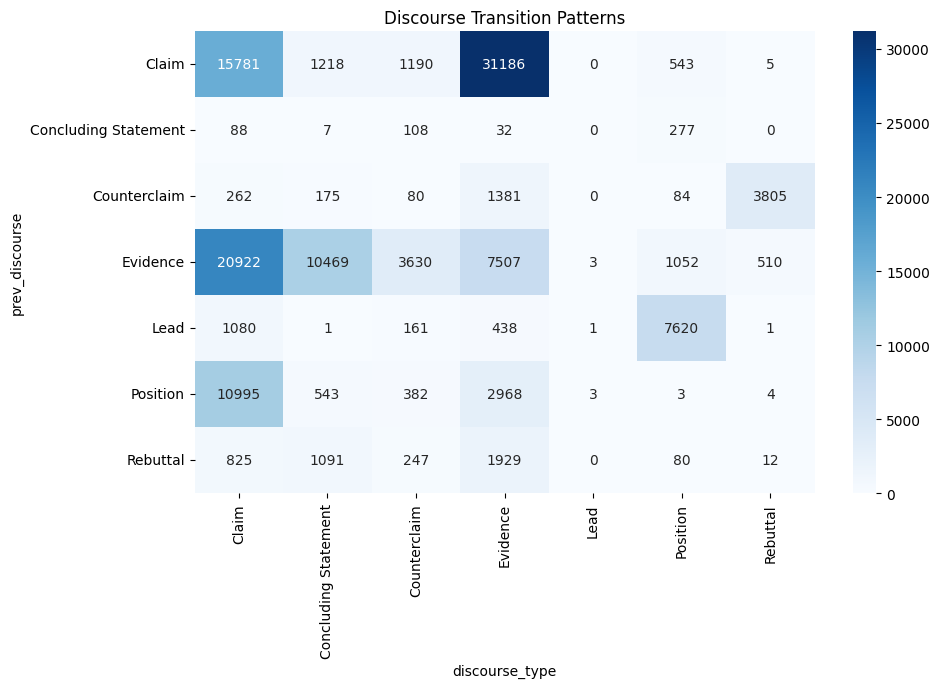

In [9]:
df_sorted = df.sort_values(by=["id", "discourse_start"])
df_sorted["prev_discourse"] = df_sorted.groupby("id")["discourse_type"].shift(1)

transition_counts = df_sorted.groupby(["prev_discourse", "discourse_type"]).size().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(transition_counts.fillna(0), cmap="Blues", annot=True, fmt=".0f")
plt.title("Discourse Transition Patterns")
plt.show()


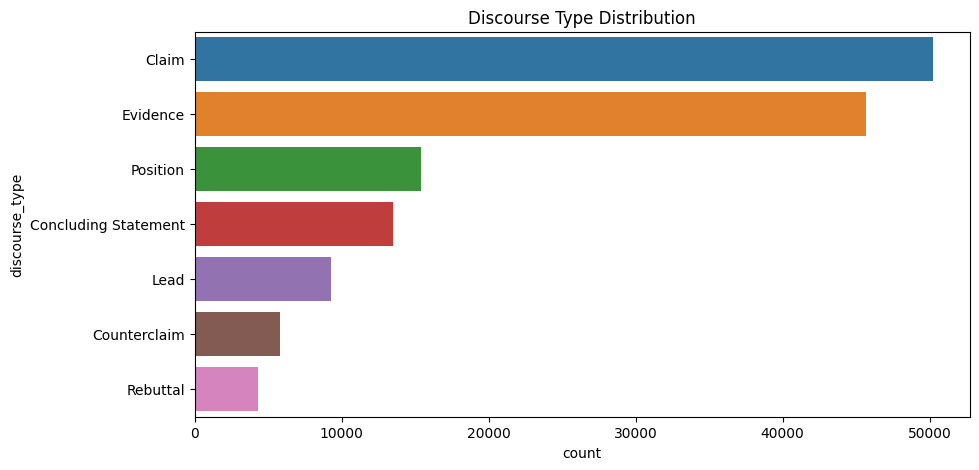

discourse_type
Claim                   50208
Evidence                45702
Position                15419
Concluding Statement    13505
Lead                     9305
Counterclaim             5817
Rebuttal                 4337
Name: count, dtype: int64


In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(y=df["discourse_type"], order=df["discourse_type"].value_counts().index)
plt.title("Discourse Type Distribution")
plt.show()
print(df["discourse_type"].value_counts())

In [11]:
df_cluster = pd.read_csv("/kaggle/input/feedback-clustering/essays_with_predictions.csv")
df_cluster.head(10)

,predicted_grade_cluster,file_name,essay_text
0,5,3321A3E87AD3.txt,I do agree that some students would benefit fr...
1,0,DFEAEC512BAB.txt,Should students design a summer project for sc...
2,2,2E4AFCD3987F.txt,"Dear State Senator\n\n,\n\nIn the ruels of vot..."
3,5,EB6C2AF20BFE.txt,People sometimes have a different opinion than...
4,0,A91A08E523D5.txt,"Dear senator,\n\nAs you know the Electoral Col..."
5,1,616F8E0EFABF.txt,"""Can you imagine a time in the future when no ..."
6,5,4E078101C9DD.txt,Some schools require students to complete summ...
7,2,B934F3106FCB.txt,When people ask for advice they automatically ...
8,1,05BE5364C50D.txt,there are many advantages to not having or lim...
9,5,96AC736B550F.txt,Imagine a world with driveless cars. While tha...


array([[<Axes: title={'center': 'predicted_grade_cluster'}>]],
      dtype=object)

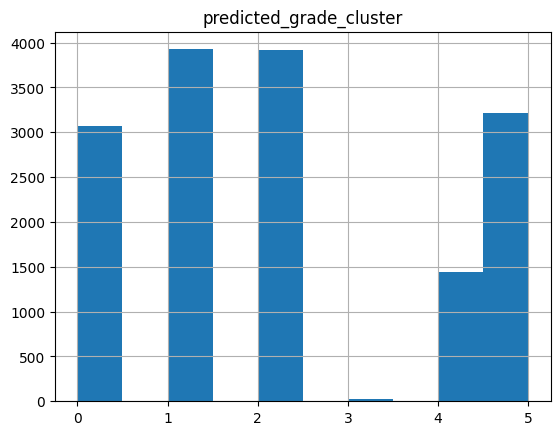

In [12]:
df_cluster.hist("predicted_grade_cluster")

In [13]:
df_cluster['id'] = df_cluster['file_name'].str.replace('.txt', '', regex=False)
df = df.merge(df_cluster[['id', 'predicted_grade_cluster']], on='id', how='left')

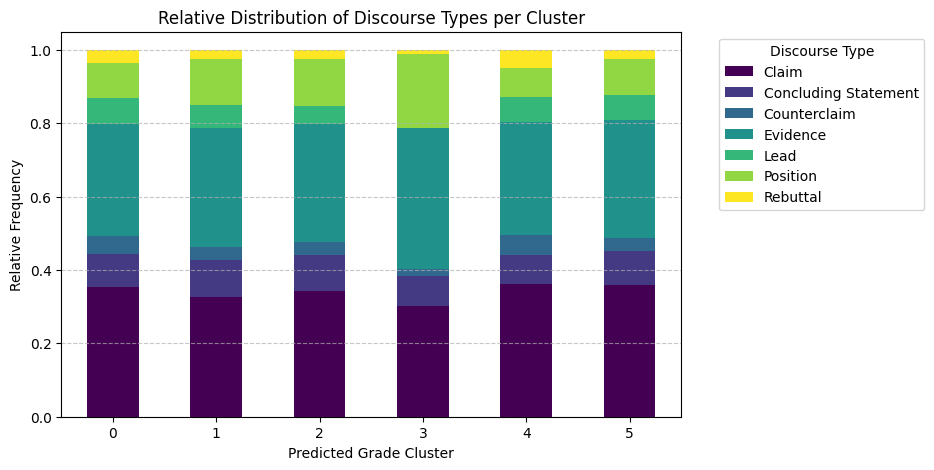

In [18]:
distribution = df.pivot_table(index="predicted_grade_cluster", columns="discourse_type", aggfunc="size", fill_value=0)
relative_distribution = distribution.div(distribution.sum(axis=1), axis=0)

ax = relative_distribution.plot(kind="bar", stacked=True, figsize=(8, 5), colormap="viridis")

plt.title("Relative Distribution of Discourse Types per Cluster")
plt.xlabel("Predicted Grade Cluster")
plt.ylabel("Relative Frequency")
plt.legend(title="Discourse Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [ ]:
def max_tokens(tokenizer, text_dir):
    max_tokens = 0
    filename = ""
    for file in os.listdir(text_dir):
        current_file = os.path.join(text_dir, file)
        with open(current_file, "r") as f:
            content = f.read().strip()
        tokenized = tokenizer(content, truncation=False, padding=False)
        num_tokens = len(tokenized["input_ids"])
        if num_tokens > max_tokens:
            max_tokens = num_tokens
            filename = current_file
    print(filename)
    # add clustering tokens
    print("Max number of tokens in corpus = ", max_tokens + 6)
    return max_tokens 
    

#### Fix CP1252 encoding

In [ ]:
import os

def fix_mixed_encoding(input_path, output_path):
    try:
        try:
            with open(input_path, 'r', encoding='utf-8') as f:
                content = f.read()
                
            with open(output_path, 'w', encoding='utf-8') as f:
                f.write(content)
            return True
            
        except UnicodeDecodeError:
            with open(input_path, 'rb') as f:
                byte_content = f.read()
            
            try:
                decoded_content = byte_content.decode('cp1252')
                with open(output_path, 'w', encoding='utf-8') as f:
                    f.write(decoded_content)
                return True
                
            except UnicodeDecodeError:
                fixed_content = bytearray()
                i = 0
                while i < len(byte_content):
                    for j in range(4, 0, -1):  # Try 4, 3, 2, 1 bytes
                        if i + j <= len(byte_content):
                            try:
                                chunk = byte_content[i:i+j].decode('utf-8')
                                fixed_content.extend(byte_content[i:i+j])
                                i += j
                                break
                            except UnicodeDecodeError:
                                continue
                    else:
                        try:
                            chunk = byte_content[i:i+1].decode('cp1252')
                            fixed_content.extend(chunk.encode('utf-8'))
                        except UnicodeDecodeError:
                            fixed_content.append(byte_content[i])
                        i += 1
                
                with open(output_path, 'wb') as f:
                    f.write(fixed_content)
                return True
                
    except Exception as e:
        print(f"Error processing {input_path}: {e}")
        return False

def process_directory(source_dir, destination_dir):
    success_count = 0
    failure_count = 0
    os.makedirs(destination_dir, exist_ok=True)
    
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            source_file_path = os.path.join(root, file)
            
            relative_path = os.path.relpath(source_file_path, source_dir)
            destination_file_path = os.path.join(destination_dir, relative_path)
            os.makedirs(os.path.dirname(destination_file_path), exist_ok=True)
            
            if fix_mixed_encoding(source_file_path, destination_file_path):
                success_count += 1
            else:
                failure_count += 1
    
    print(f"\nProcessing complete. Successfully fixed: {success_count}, Failed: {failure_count}")
